In [1]:
# From Chapter 2 of Hands-on Unsupervised Learning Textbook
# Also, from https://www.kaggle.com/mlg-ulb/creditcardfraud

'''Main'''
import numpy as np
import pandas as pd
from time import time

'''Data Prep'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# data visualisation
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

In [2]:
# read data
data = pd.read_csv('credit_card.csv')
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [3]:
# Create the feature matrix X and the labels array Y
dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

In [4]:
# standardize X
featuresToScale = dataX.drop(['Time'],axis=1).columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
dataX.describe()
# now all rows have mean=0 and stderr=1

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,94813.859575,-7.894416e-16,2.647157e-17,-4.302564e-15,-6.662098e-16,-2.586322e-16,4.147497e-16,-8.820879e-16,-2.466016e-16,3.102531e-16,...,2.589559e-16,1.869947e-17,1.494373e-15,-6.977058e-16,1.151050e-16,-7.959207e-16,3.444180e-16,-2.454881e-18,5.251749e-17,3.202236e-16
std,47488.145955,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,0.000000,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,...,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,54201.500000,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,...,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,84692.000000,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,...,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,139320.500000,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,...,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,172792.000000,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,...,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2,
random_state=2, stratify=dataY)

In [6]:
# Case 1: hyperparameter tuning by grid search
from sklearn.model_selection import cross_val_score, cross_validate
import time as time
from tqdm import tqdm
import os, pickle

# 5-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=False)

# the following is a self-defined function so it is easier for us to try out different algorithms
def compute_fold_acc(classifier, tuning_params):
    results = {}
    for feature in tqdm(tuning_params): # tqdm is the function for progress bar
        auc_scores = [] # auc is the evaluation metric, this is just a declaration of output variable name
        for param in tuning_params[feature]:
            # initialise classifier
            clf = classifier(**{feature:param},random_state=1,use_label_encoder=False,eval_metric='error')
            # stratified k-fold cross validation            
            # The following line can be improved, we should take dataframe as input argment, 
            # rather than hard coding data here
            cv_model = cross_val_score(clf, X_train, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)
            # calculate auc score
            auc_scores.append(cv_model.mean())
        results[feature] = {
            'AUC':auc_scores, feature:tuning_params[feature]
        }
    return results

# The following self-defined function is less important, it is for visualizing results
def visualise_fold(result):
    if len(result)!=1:
        n_row = len(result)//2+len(result)%2
        fig, axes = plt.subplots(nrows=n_row, ncols=2, figsize=(35, 5*n_row), squeeze=False)
        for idx, feature in enumerate(result):
            row = idx//2; col = idx%2
            train_acc = result[feature]['AUC']
            feature_vals = result[feature][feature]
            axes[row][col].plot(feature_vals, train_acc, 'b', label='AUC')
            axes[row][col].grid(True)
            axes[row][col].set(xlabel=feature, ylabel='Cross Validated AUC')
    else:
        feature = list(result.keys())[0]
        fig = plt.figure(figsize=(35,5))
        train_acc = result[feature]['AUC']
        feature_vals = result[feature][feature]
        plt.plot(feature_vals, train_acc, 'b', label='AUC')
        plt.grid(True)
        plt.xlabel(feature)
        plt.ylabel('Cross Validated AUC')

In [7]:
xg_tuning_params = {
    'eta': np.linspace(0.01, 0.3, 2, endpoint=True),
    'max_depth': [i for i in range(3, 4)],
    #'subsample':  np.linspace(0.5, 1.0, 2, endpoint=True),
    #'colsample_bytree': np.linspace(0.5, 1.0, 2, endpoint=True),
    #'colsample_bylevel': np.linspace(0.5, 1.0, 2, endpoint=True),
    #'colsample_bynode': np.linspace(0.5, 1.0, 2, endpoint=True),
    'n_estimators': [i*25 for i in range(2,4)],
    # 'gamma':[i for i in range(0,2)]
    # 'min_child_weight': np.linspace(1.0, 5.0, 2, endpoint=True)
    #'reg_lambda': list(range(1,2)),
    #'reg_alpha': np.linspace(0.01, 0.1, 2, endpoint=True)
}

In [8]:
from xgboost import XGBClassifier
# initialise XGBoost classifier
# xgb = XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='error')

# The following will take quite long
start_time = time.time()
fold_acc = compute_fold_acc(XGBClassifier, xg_tuning_params)
print("--- %s seconds ---" % (time.time() - start_time))
# it takes about one hour on my laptop with all processors to try 225 combinations

100%|██████████| 3/3 [05:09<00:00, 103.17s/it]

--- 309.52378940582275 seconds ---


In [9]:
print(fold_acc)

{'eta': {'AUC': [0.9160777741274739, 0.9720949730382751], 'eta': array([0.01, 0.3 ])}, 'max_depth': {'AUC': [0.9764741068916051], 'max_depth': [3]}, 'n_estimators': {'AUC': [0.9718510952405228, 0.9712721316611843], 'n_estimators': [50, 75]}}


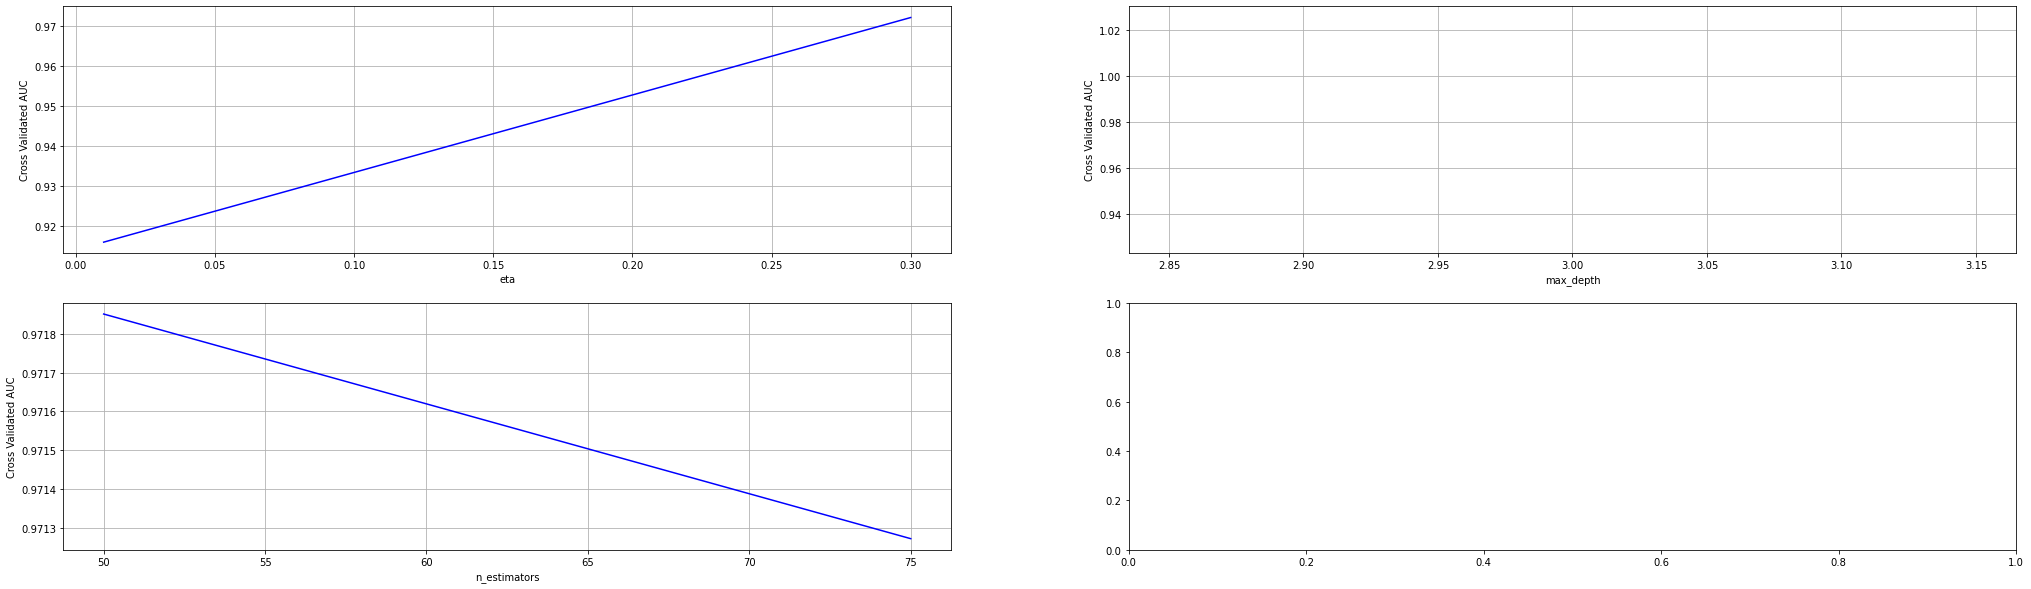

In [10]:
# visualize AUC Results
visualise_fold(fold_acc)
# For each hyper-parameter, we have one chart showing one dimensional tuning results